In [1]:
#!git clone https://github.com/chiggum/pyLDLE2.git

Cloning into 'pyLDLE2'...
remote: Enumerating objects: 1902, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 1902 (delta 87), reused 141 (delta 51), pack-reused 1716
Receiving objects: 100% (1902/1902), 801.25 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (837/837), done.
Updating files: 100% (102/102), done.


In [2]:
#!pip install multiprocess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00


In [3]:
import sys
sys.path.insert(0, './pyLDLE2/')

In [11]:
import numpy as np
from pyLDLE2 import util_, visualize_, datasets
from scipy.sparse import coo_matrix
from scipy import optimize
from scipy.special import erf, erfinv
from matplotlib import pyplot as plt
from scipy.stats import chi2
from sklearn.decomposition import PCA

In [5]:
vis = visualize_.Visualize()

In [6]:
X, labelsMat, ddX = datasets.Datasets().disk_checkerboard_uniform(n=10000, noise=0.05)

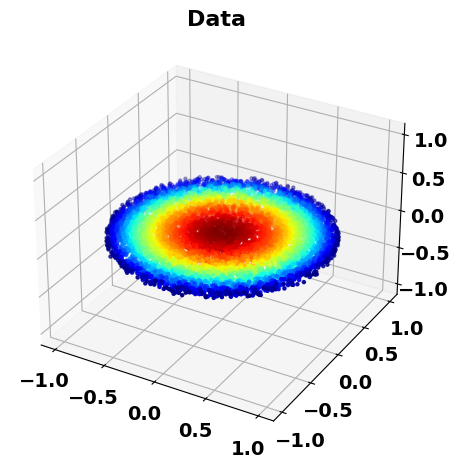

In [7]:
vis.data(X, ddX)

In [8]:
k_nn = 128
neigh_dist, neigh_ind = util_.nearest_neighbors(X, k_nn, metric='euclidean')

In [9]:
h_cand = np.sqrt(2)*neigh_dist[:,-1]/np.sqrt(chi2.ppf(0.99, df=2))
print(np.min(h_cand), np.median(h_cand), np.max(h_cand))
h = np.min(h_cand)

0.055253021371142096 0.06453014409795634 0.0990674314574932


In [12]:
neigh_dist = np.zeros(neigh_dist.shape)
for i in range(neigh_dist.shape[0]):
    X_i_nbrs = X[neigh_ind[i,:].tolist(),:]
    pca = PCA(n_components=2)
    y = pca.fit_transform(X_i_nbrs)
    X_rec = pca.inverse_transform(y)
    temp = X_rec - X_rec[0,:][None,:]
    neigh_dist[i,:] = np.linalg.norm(temp, axis=1)

In [13]:
K = np.exp(-neigh_dist**2/h**2)

In [14]:
n = X.shape[0]
source_ind = np.repeat(np.arange(n),neigh_ind.shape[1])
K = coo_matrix((K.flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))
ones_K_like = coo_matrix((np.ones(neigh_dist.shape).flatten(),(source_ind, neigh_ind.flatten())),shape=(n,n))

# symmetrize
K = K + K.T
ones_K_like = ones_K_like + ones_K_like.T
K.data /= ones_K_like.data

In [15]:
# mu_hN_norm = np.zeros(X.shape[0])
# for i in range(X.shape[0]):
#     temp = X-X[i,:][None,:]
#     mu_hN_norm[i] = np.linalg.norm(K.getrow(i).dot(temp))

mu_hN_norm = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    X_i_nbrs = X[neigh_ind[i,:].tolist(),:]
    pca = PCA(n_components=2)
    y = pca.fit_transform(X_i_nbrs)
    X_rec = pca.inverse_transform(y)
    temp = X_rec - X_rec[0,:][None,:]
    mu_hN_norm[i] = np.linalg.norm(K.getrow(i)[0,neigh_ind[i,:]].dot(temp))

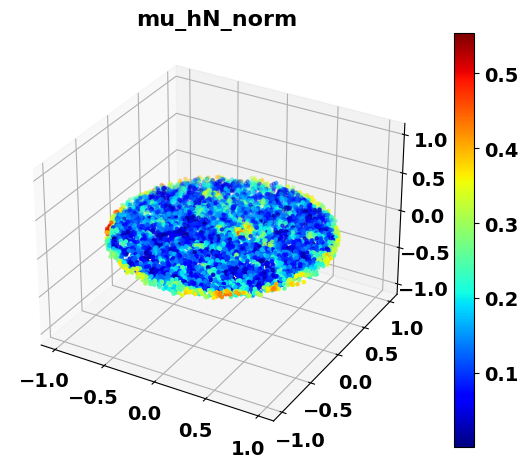

In [16]:
vis.data(X, mu_hN_norm, title='mu_hN_norm', colorbar=True)

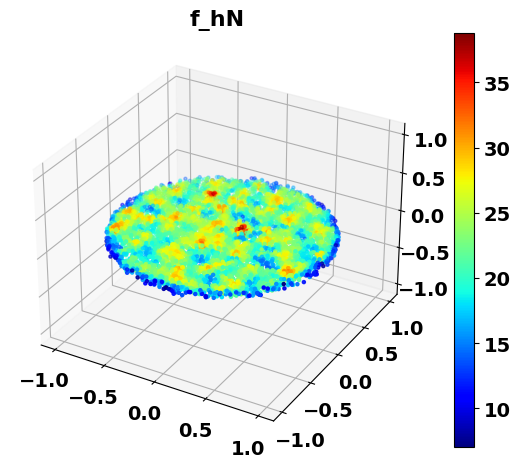

In [17]:
vis.data(X, np.array(K.sum(axis=1)).flatten(), title='f_hN', colorbar=True)

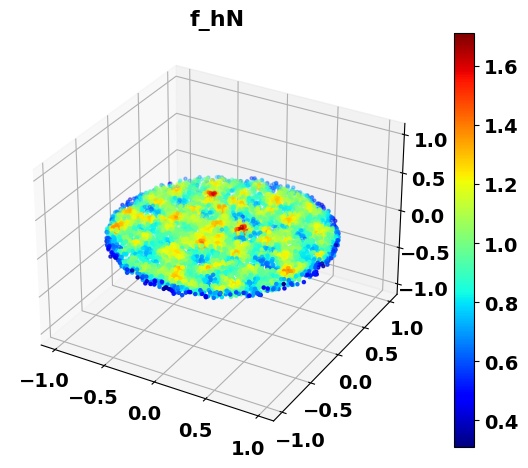

In [18]:
vis.data(X, np.array(K.sum(axis=1)).flatten()/(n*h**2), title='f_hN', colorbar=True)

In [19]:
c_num = h*np.array(K.sum(axis=1)).flatten()/np.sqrt(np.pi)
c_denom = mu_hN_norm
c = c_num/(c_denom+1e-20)

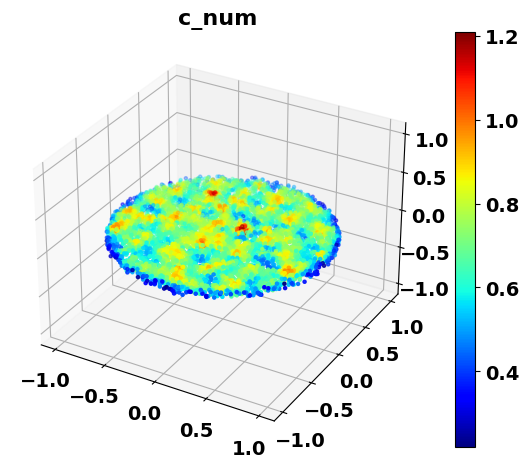

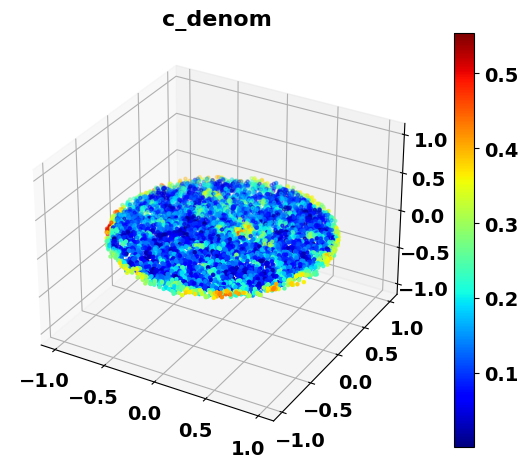

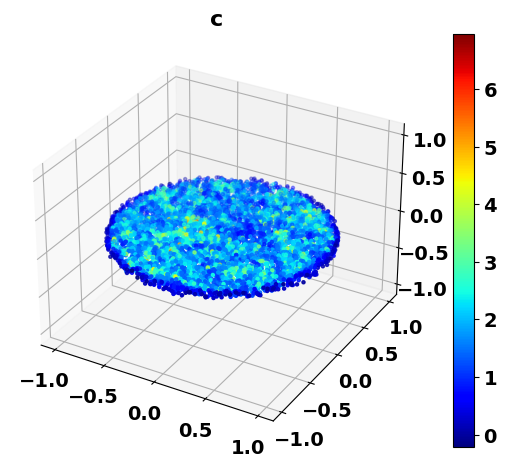

In [20]:
vis.data(X, c_num, title='c_num', colorbar=True)
vis.data(X, c_denom, title='c_denom', colorbar=True)
vis.data(X, np.log(c), title='c', colorbar=True)

In [21]:
def F(x):
    return c_denom*(1+erf(x/h))*np.exp(x**2/h**2)-c_num

def F_prime(x):
    return (c_denom/h)*(2/np.sqrt(np.pi) + 2*(1+erf(x/h))*np.exp(x**2/h**2)*x/h)

In [22]:
bx_init = h*np.sqrt(np.maximum(0, -np.log(2*c_denom+1e-30)+np.log(c_num+1e-30)))

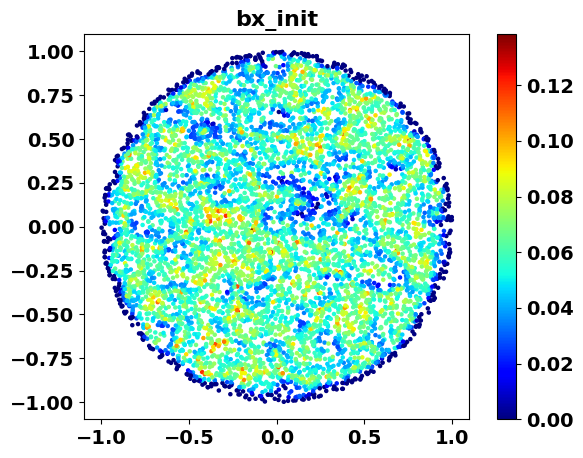

In [23]:
vis.data(X[:,:2], bx_init, title='bx_init', colorbar=True)

In [24]:
bx = optimize.newton(F, bx_init, F_prime, maxiter=10000)

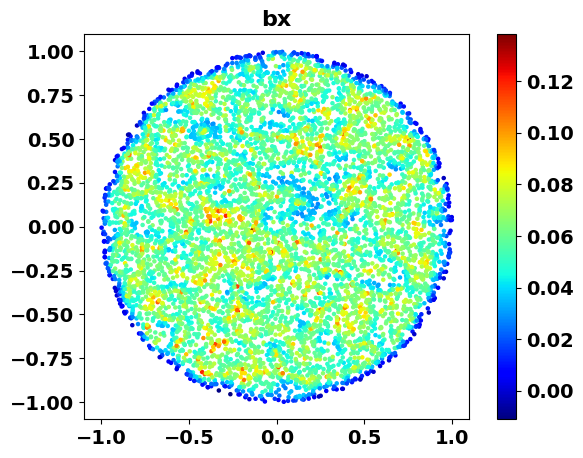

In [25]:
vis.data(X[:,:2], bx, title='bx', colorbar=True)

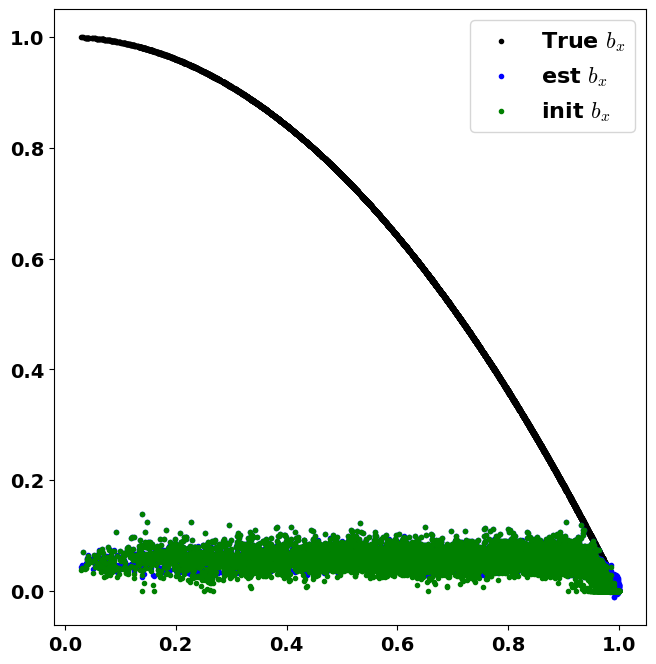

In [26]:
plt.figure(figsize=(8,8))
plt.scatter(np.linalg.norm(X[:,:2], axis=1), ddX, color='k', label='True $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx, color='b', label='est $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx_init, color='g', label='init $b_x$')
plt.axis('image')
plt.legend()

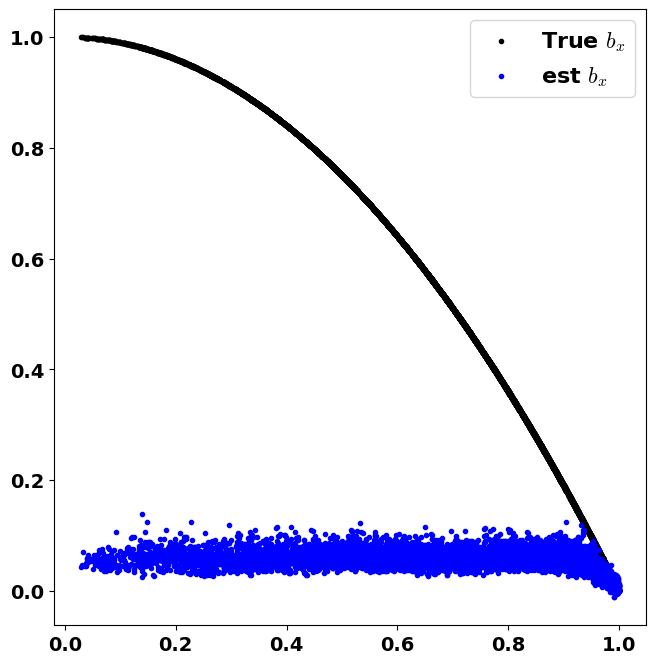

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(np.linalg.norm(X[:,:2], axis=1), ddX, color='k', label='True $b_x$')
plt.scatter(np.linalg.norm(X[:,:2], axis=1), bx, color='b', label='est $b_x$')
plt.axis('image')
plt.legend()

In [28]:
np.linalg.norm(bx - ddX) / np.linalg.norm(ddX)

0.9105914568182676